# ПРОЕКТ: РАЗМЕТКА ДОКУМЕНТА

#### Intro

Входящие данные: файл InDesign со стандартной стилевой разметкой

Исходящие данные: файл InDesign с расширенной разметкой 


#### Краткий план

Файл разбивается на абзацы, каждый абзац парсится на предмет всех его свойств (таких как содержимое, стиль, кегль, гарнитура etc.), из которых формируются признаки для модели машинного обучения.

Целевой признак - стиль абзаца. 

Далее разметка приводится в соответствие тому, что приходит на верстку от редактора.  
Большинство классов будут соответствовать стилю абзаца, добавятся лишь начала/концы вставочных элементов:
* преамбул;
* примеров;
* тематических вставок etc.

Далее проведем EDA полученного датасета, займемся генерацией новых признаков и т. д.

После получения готового к машинному обучению набора данных обучим несколько моделей, чтобы выявить лучшую.

Метрика качества (предварительно) - F1.

По итогу выбора лучшей модели прогоним ее на тестовом файле, из которого формируется датасет аналогичным образом.


## Подготовка к работе

Импортируем необходимвые библиотеки, напишем функции для обработки документов и датасетов

#### Библиотеки и параметры

In [2]:
# improts
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import win32com.client

from catboost import CatBoostClassifier, Pool, cv
from category_encoders import MEstimateEncoder
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
import re
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    precision_score, 
    accuracy_score
    )
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    LabelEncoder
    )
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import torch
import transformers
from tqdm import notebook




#Random state
RS = 45364

#Parameters
app = win32com.client.Dispatch('InDesign.Application.2023')
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', 40)
pd.set_option('mode.chained_assignment', None)



#### Функции для обработки документов и датасетов

In [3]:
# Определим документ

my_doc = app.ActiveDocument

In [4]:
def get_stlyes_id(document):
    styles = {}
    for st in document.allParagraphStyles:
        styles[st.id] = st.parent.name, st.name

    styles_df = pd.DataFrame.from_dict(
                            styles, 
                            #columns=['style_id', 'style_group', 'style_name']
                            
    ).T
    styles_df = styles_df.reset_index()
    styles_df.rename(columns={'index': 'style_id', 0: 'style_group', 1: 'style_name'}, inplace=True)

    return styles_df

In [5]:
# Get style names and ID's from template

template_doc = app.Open(r"d:\Work\Urait\#TEST_ШАБЛОНЫ КНИГ 2019\[2019]Шаблон Бакалавр 70х100_16.indd")

template_styles = get_stlyes_id(template_doc)


# Without saving option code
idNo = 1852776480

template_doc.Close(idNo)



In [6]:
# template_styles = template_styles.reset_index()
# template_styles.rename(columns={'index': 'style_id', 0: 'style_group', 1: 'style_name'}, inplace=True)

template_styles

,style_id,style_group,style_name
0,97,[2019]Шаблон Бакалавр 70х100_16.indd,[Без стиля]
1,101,[2019]Шаблон Бакалавр 70х100_16.indd,[основной абзац]
2,179425,Титул,Оборот титула
3,184166,Титул,Библиография
4,184165,Титул,Титул_Заголовки
...,...,...,...
56,50035,Оглавление,(O) 11.1
57,50036,Оглавление,(O) 11.11
58,50037,Оглавление,(O) 1.1.1.
59,50038,Оглавление,(О) Приложение к главе


In [7]:
def compare_styles(my_doc):
    
    data_styles = get_stlyes_id(my_doc)

    comp = data_styles.merge(
                    template_styles, 
                    how='left', 
                    indicator=True) \
    .query("_merge == 'left_only'") \
    .drop('_merge', axis=1)[data_styles.columns]
    
    return comp



In [8]:
def get_main_story(my_doc):
    '''
    Return max story in document
    '''

    story_lens = []

    for i in range(1, my_doc.Stories.Count):
        story_lens.append(my_doc.Stories.Item(i).Paragraphs.Count)


    print('Max story length:', max(story_lens), 
          '\nStories:', len(story_lens), 
          '\nMax story index:', story_lens.index(max(story_lens)))

    main_story = my_doc.Stories[story_lens.index(max(story_lens))]

    print('Paragraphs in max story:', (main_story.Paragraphs.Count))

    return main_story


In [9]:
def add_styles(my_doc):
    # Добавляет лишние стили. Сделать проверку на наличие
    try:
        eqn_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.Add()
        eqn_end.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item("Пример с плашкой_Конец")
        eqn_end.Name = "Пример формула конец"
        eqn_end.firstLineIndent = 0
        eqn_end.spaceBefore = 4
        eqn_end.Justification = 1667591796 # 'CENTER_ALIGN'
        eqn_end.ruleBelow = True
        eqn_end.ruleBelowLineWeight = 0.5
        eqn_end.ruleBelowOffset = 4
        #print(eqn_end.Name)
    
    except:
        eqn_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример формула конец')

        print('target_style', eqn_end.Name, ' is on!!!!')

    try:
        pic_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.Add()
        pic_end.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Рисунок').paragraphStyles.item("Подрисуночная подпись")
        pic_end.Name = "Пример рисунок конец"
        pic_end.ruleBelow = True
        pic_end.ruleBelowLineWeight = 0.5
        pic_end.ruleBelowOffset = 4
        #print(pic_end.Name)
    
    except:
        pic_end = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример рисунок конец')
        print('target_style', pic_end.Name, ' is on!!!!')

    try:
        eqn_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.Add()
        eqn_end_sans.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item("Пример с плашкой_Конец")
        eqn_end_sans.Name = "Пример Р формула конец"
        eqn_end_sans.firstLineIndent = 0
        eqn_end_sans.spaceBefore = 4
        eqn_end_sans.Justification = 1667591796 # 'CENTER_ALIGN'
        eqn_end_sans.ruleBelow = True
        eqn_end_sans.ruleBelowLineWeight = 0.5
        eqn_end_sans.ruleBelowOffset = 4
        #print(eqn_end_sans.name)
    
    except:
        eqn_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item('Пример Р формула конец')
        print('target_style', eqn_end_sans.Name, ' is on!!!!')
    
    try:
        pic_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.Add()
        pic_end_sans.basedOn = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Рисунок').paragraphStyles.item("Подрисуночная подпись")
        pic_end_sans.Name = "Пример Р рисунок конец"
        pic_end_sans.ruleBelow = True
        pic_end_sans.ruleBelowLineWeight = 0.5
        pic_end_sans.ruleBelowOffset = 4
        #print(pic_end_sans.name)
    
    except:
        pic_end_sans = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой рубленый').paragraphStyles.item('Пример Р рисунок конец')
        print('target_style', pic_end_sans.Name, ' is on!!!!')

In [10]:
def get_paragraphs(main_story):
    '''
    in: story
    out: list of paragraphs in story
    '''
    pre_data = []

    for i in range(1, main_story.Paragraphs.Count):
        pre_data.append(main_story.paragraphs.Item(i))
    return pre_data


In [11]:
def features_engineering(pre_data, max_shift=7):
    """
    Make features form paragraphs state,
    i.e. style, font, font size etc.
    """

    data = pd.DataFrame(pre_data, columns=['paragraph'])

    data['content'] = data['paragraph'].apply(lambda x: x.contents.strip()).str.replace('\ufeff', '')

    # data['content'] = full_data['content'].str.replace('\ufeff', '')

    # Features

    data['align'] = data['paragraph'].apply(lambda x: x.Justification).replace(map_replace_align)

    data['style_group'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.Parent.name)

    data['target_style_id'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.id)
    data['target_style'] = data['paragraph'].apply(lambda x: x.appliedParagraphStyle.name)

    for shift in range(1, max_shift):
        data['prev_' + str(shift) + '_style'] = data['target_style_id'].shift(shift).fillna(0).astype('int')
        data['next_' + str(shift) + '_style'] = data['target_style_id'].shift(-shift).fillna(0).astype('int')
        


    # data['prev_second_style'] = data['target_style_id'].shift(2)
    # data['prev_style'] = data['target_style_id'].shift(1)
    # data['next_style'] = data['target_style_id'].shift(-1)
    # data['next_second_style'] = data['target_style_id'].shift(-2)

    data['font_name'] = data['paragraph'].apply(lambda x: x.appliedFont.name.split('\t')[0])
    data['font_size'] = data['paragraph'].apply(lambda x: x.pointSize)

    data['space_before'] = data['paragraph'].apply(lambda x: x.spaceBefore)
    data['space_after'] = data['paragraph'].apply(lambda x: x.spaceAfter)
    
    data['left_ident'] = data['paragraph'].apply(lambda x: x.leftIndent)
    data['right_ident'] = data['paragraph'].apply(lambda x: x.rightIndent)
    data['first_line_ident'] = data['paragraph'].apply(lambda x: x.firstLineIndent)

    data['is_pict_on'] = (data['content'].str.contains('Рис\.|рис\.|Рисун', regex=True)) & (data['target_style'] != 'Подрисуночная подпись')
    data['is_table_on'] = data['content'].str.contains('Табл\.|табл\.', regex=True) & (data['target_style'] != 'Табл. номер')
    data['is_eqn_on'] = data['content'].str.contains('\(\d+\.\d+\)', regex=True) & (data['target_style'] != 'Формула однострочная') & (data['target_style'] != 'Формула 5 мм') & (data['target_style'] != 'Формула высокая') & (data['target_style'] != 'Формула ПРИМЕР')

    data['length'] = data['content'].apply(lambda x: len(x))
    data['words_count'] = data['content'].apply(lambda x: len(x.split()))
    
    data['start_with_digits'] = data['content'].apply(
        lambda x: (len(re.search(r'^(\d+\.)((\d+\.)+)', x)[0].split('.')[:-1])) 
        if re.search(r'^(\d+\.)((\d+\.)+)', x) 
        else 0
        )
    data['editor_style'] = data['target_style_id']

    data.fillna(0, inplace=True)
    
    # Target 

    # data['group+style'] = data['style_group'] + ' &&& ' + data['target_style']

    # Delete empty lines
    # data = data.query('content != ""')
    
    return data



In [12]:
def editor_emulate(data):
    data.loc[data['target_style'].isin(['Пример Р формула конец', 'Пример Р рисунок конец']), 'editor_style'] = 184113 #
    data.loc[data['target_style'].isin(['Пример формула конец', 'Пример рисунок конец']), 'editor_style'] = 177705 #
    data.loc[
        data['target_style'].isin(['Пример с плашкой_ Заголовок', 'Пример с плашкой_Конец']) & \
        (data['style_group'] == 'Пример с плашкой рубленый'), 
        'editor_style'
        ] = 184113 #
    data.loc[
        data['target_style'].isin(['Пример с плашкой_ Заголовок', 'Пример с плашкой_Конец']) & \
        (data['style_group'] == 'Пример с плашкой'), 
        'editor_style'
        ] = 177705 #
    data.loc[data['target_style'].isin(['Петит Начало', 'Петит Окончание']), 'editor_style'] = 50028 # Петит внутри
    data.loc[data['target_style'].isin(['Преамбула к главе начало', 'Преамбула к главе внутри', 'Преамбула к главе конец']), 'editor_style'] = 144256 #Преамбула полная
    data.loc[data['style_group'] == 'Формулы', 'editor_style'] = 184117 # 'Формула 5 мм'
    data.loc[data['style_group'].isin(['Пример с плашкой', 'Преамбулы к главе', 'Пример с плашкой рубленый']), 'space_before'] = 0
    data.loc[data['style_group'].isin(['Пример с плашкой', 'Преамбулы к главе', 'Пример с плашкой рубленый']), 'space_after'] = 0

    return data


In [13]:
# template_styles[template_styles.style_name == 'Пример с плашкой_ Внутри']

In [14]:
#import indesign_2021 as indd

map_replace_align = {
    1667591796: 'Center',
    1818584692: 'Left',
    1919379572: 'Right',
    1818915700: 'Justifed'
}

# map_replace_align

#### Формирование датафрейма и добавление новых признаков

In [15]:
# data = 2503
# data2 = 43507
# data3 =  3252
main_story = get_main_story(my_doc)

add_styles(my_doc)

pre_data = get_paragraphs(main_story)

Max story length: 6801 
Stories: 1603 
Max story index: 4
Paragraphs in max story: 6801
target_style Пример формула конец  is on!!!!
target_style Пример рисунок конец  is on!!!!
target_style Пример Р формула конец  is on!!!!
target_style Пример Р рисунок конец  is on!!!!


In [16]:
data = features_engineering(pre_data)

In [17]:
data = editor_emulate(data)

data = data.query('content != ""')

In [18]:
data

,paragraph,content,align,style_group,target_style_id,target_style,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_name,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,editor_style
0,<COMObject Item>,Предисловие,Center,навигация по книге,50009,Приложения к книге,0,50004,0,50004,0,50004,0,50004,0,50004,0,50004,Myriad Pro,18.0,10.0,8.0,0.0,0.0,0.0,False,False,False,11,1,0,50009
1,<COMObject Item>,Предлагаемый курс возник как итог многолетней ...,Justifed,основной набор,50004,Основной текст,50009,50004,0,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,997,114,0,50004
2,<COMObject Item>,Данный курс адресован в первую очередь студент...,Justifed,основной набор,50004,Основной текст,50004,50004,50009,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,738,88,0,50004
3,<COMObject Item>,"Преамбула, с которой начинается каждая тема, в...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50009,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,562,76,0,50004
4,<COMObject Item>,"Излагая теорию, авторы зачастую отказываются о...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50009,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,829,105,0,50004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,<COMObject Item>,"27.\tСеменов, В. А. Математические методы в гу...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,50004,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,202,33,0,50004
6796,<COMObject Item>,"28.\tСухотин, А. М. Высшая математика. Альтерн...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,209,33,0,50004
6797,<COMObject Item>,"29.\tХорошилова, Е. В. Высшая математика. Лекц...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,176,30,0,50004
6798,<COMObject Item>,"30.\tШипачев, В. С. Высшая математика : учебно...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,0,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,179,33,0,50004


In [19]:
compare_styles(my_doc)

,style_id,style_group,style_name
0,97,2503_19_978-5-534-18373-3 - рубленые примеры.indd,[Без стиля]
1,101,2503_19_978-5-534-18373-3 - рубленые примеры.indd,[основной абзац]
16,275290,Пример с плашкой,Пример формула конец
17,279574,Пример с плашкой,Пример рисунок конец
18,321428,Пример с плашкой,Стиль абзаца 1
19,321429,Пример с плашкой,Стиль абзаца 2
25,317942,Пример с плашкой рубленый,Пример Р рисунок конец
26,317943,Пример с плашкой рубленый,Пример Р формула конец
27,321431,Пример с плашкой рубленый,Стиль абзаца 1
28,321432,Пример с плашкой рубленый,Стиль абзаца 2


## Анализ данных

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6794 entries, 0 to 6799
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          6794 non-null   object 
 1   content            6794 non-null   object 
 2   align              6794 non-null   object 
 3   style_group        6794 non-null   object 
 4   target_style_id    6794 non-null   int64  
 5   target_style       6794 non-null   object 
 6   prev_1_style       6794 non-null   int32  
 7   next_1_style       6794 non-null   int32  
 8   prev_2_style       6794 non-null   int32  
 9   next_2_style       6794 non-null   int32  
 10  prev_3_style       6794 non-null   int32  
 11  next_3_style       6794 non-null   int32  
 12  prev_4_style       6794 non-null   int32  
 13  next_4_style       6794 non-null   int32  
 14  prev_5_style       6794 non-null   int32  
 15  next_5_style       6794 non-null   int32  
 16  prev_6_style       6794 

In [21]:
data.describe()

,target_style_id,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits,editor_style
count,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000,6794.000000
mean,94804.900206,94797.546659,94797.543568,94790.186635,94762.447012,94782.826612,94755.080512,94775.463056,94744.062261,94768.105093,94736.702826,94760.740065,94729.342802,9.897630,0.952311,1.172358,1.099205,0.641743,3.429497,81.242420,12.207389,0.015308,99303.605387
std,66861.321352,66869.001128,66869.003199,66876.683551,66875.703284,66884.364280,66883.385406,66892.045682,66888.015900,66899.721649,66895.688450,66907.400652,66903.361114,1.077011,1.959645,2.169902,4.966058,1.672511,2.320954,137.972304,19.106275,0.174314,61969.211775
min,50004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,50004.000000
25%,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000,50004.000000
50%,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,10.000000,0.000000,0.000000,0.000000,0.000000,5.000000,37.000000,6.000000,0.000000,50026.000000
75%,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,156680.000000,10.500000,1.000000,2.000000,0.000000,0.000000,5.000000,99.000000,14.000000,0.000000,182511.000000
max,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,317943.000000,20.000000,24.000000,34.000000,50.000000,5.000000,5.000000,2188.000000,283.000000,2.000000,184319.000000


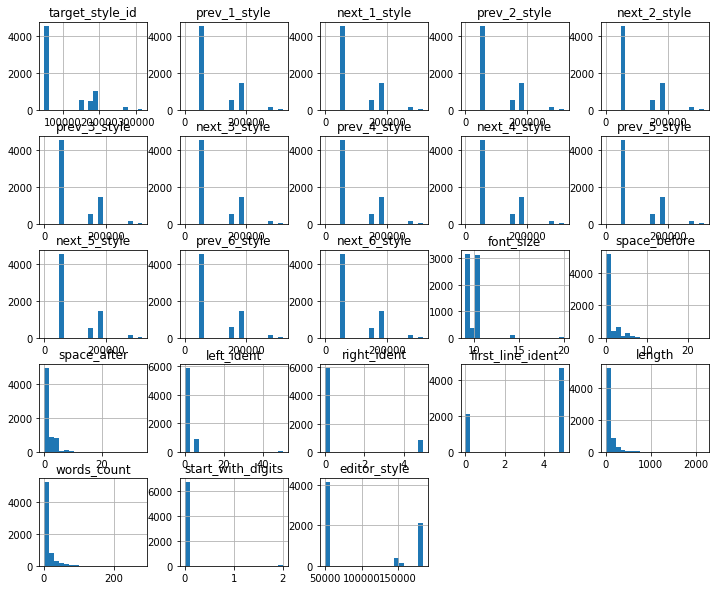

In [22]:
data.hist(figsize=(12, 10), bins=20);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Длина абазаца в символах в большинстве случаев - около 100, впятеро меньше абзацев длиной 200-300 символом.  
Также есть огромные абзацы длиной от 500 до 2188 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [23]:
style_pivot = data.pivot_table(
    index=['style_group', 'target_style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,target_style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,238,238,79.865546,10.579832
1,Преамбулы к главе,Преамбула к главе конец,20,20,45.900000,5.800000
2,Преамбулы к главе,Преамбула к главе начало,20,20,1079.700000,146.700000
3,Пример с плашкой,Пример рисунок конец,14,14,8.285714,2.000000
4,Пример с плашкой,Пример с плашкой_ Внутри,228,228,88.307018,13.951754
5,Пример с плашкой,Пример с плашкой_ Заголовок,90,90,9.966667,1.988889
6,Пример с плашкой,Пример с плашкой_Конец,42,42,156.476190,24.023810
7,Пример с плашкой,Пример формула конец,34,34,1.205882,1.029412
8,Пример с плашкой рубленый,Пример Р рисунок конец,13,13,8.307692,2.000000
9,Пример с плашкой рубленый,Пример Р формула конец,33,33,1.181818,1.030303


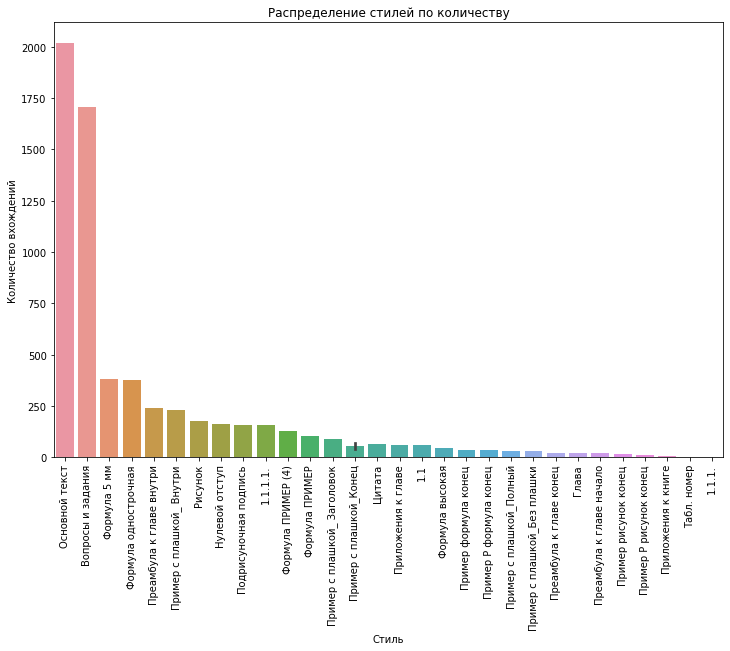

In [24]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Очевидно, но основной текст - наиболее часто используемый стиль.

Учебник также достаточно сильно насыщен контрольными вопросами и заданиями.

Довольно большое количество рисунков, много формул.  
Вероятно, это книжка по естественно-научной дисциплине :)

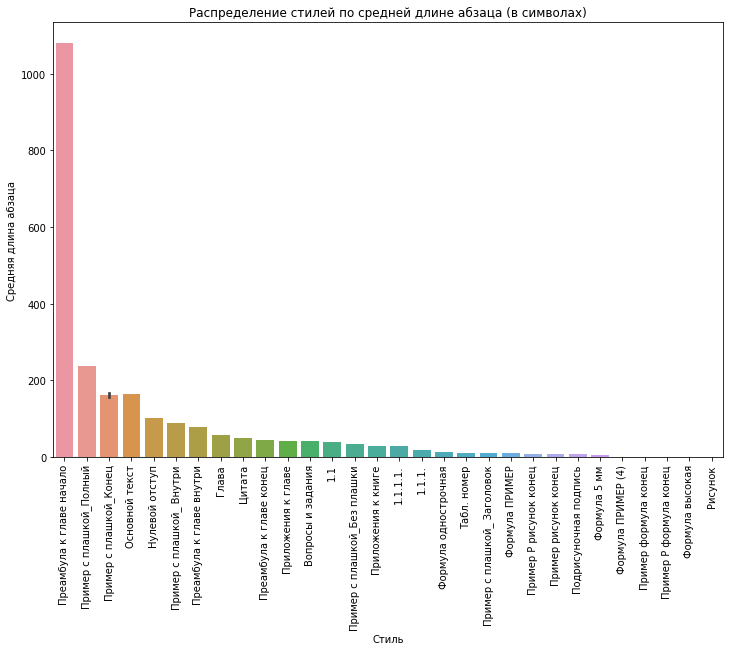

In [25]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Странный лидер графика.  
Не видя текста, но зная структуру учебников, вполне можно предположить, что каждая глава содержит объемное вступление в преамбуле.  
Также отмечу довольно большой объем (в среднем!) замечаний (стили "Пример с плашкой полный" и "...без плашки").

Основной текст лишь на 4 месте со средней длиной абзаца около 200 символов.  
Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает

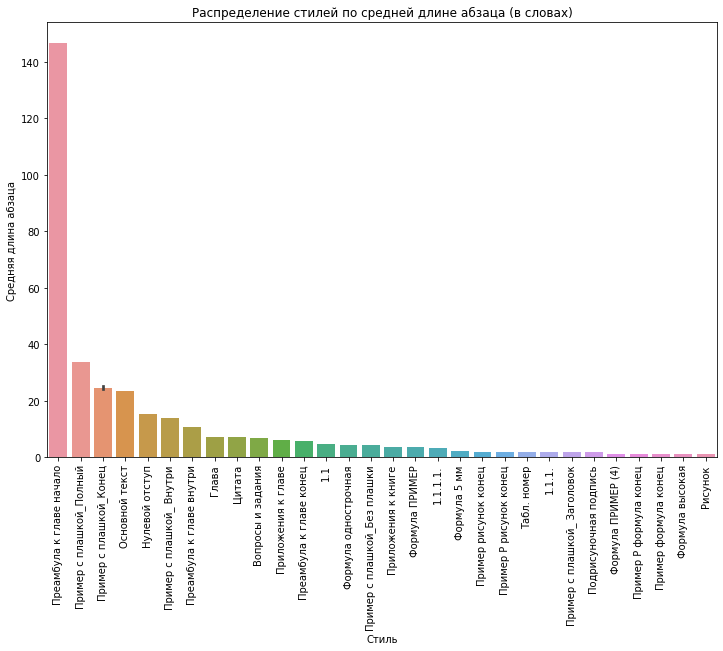

In [26]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

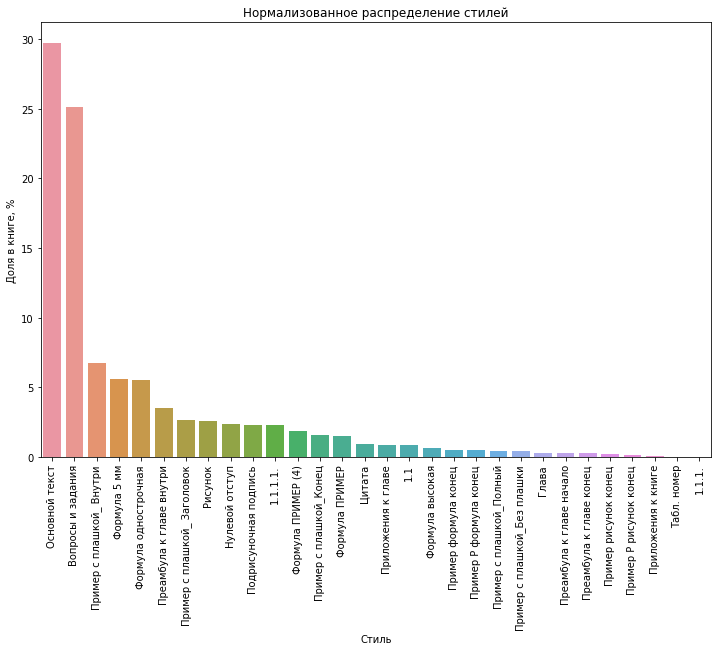

In [27]:
sns.barplot(
    x=data['target_style'].value_counts(normalize=True).index,
    y=data['target_style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

## Расширение данных

Добавим еще пару книг для увеличения объема данных

In [28]:
# ToDo - функция с загрузкой документов из папки

In [29]:
# Переопределим документ data2 = 43507
my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles(my_doc)

# Определим main_story
main_story2 = get_main_story(my_doc)

# Разобьем на абзацы и создадим еще один датафрейм
pre_data2 = get_paragraphs(main_story2)
data2 = features_engineering(pre_data2)

data2 = editor_emulate(data2)


data2

target_style Пример формула конец  is on!!!!
target_style Пример рисунок конец  is on!!!!
Max story length: 5836 
Stories: 1643 
Max story index: 4
Paragraphs in max story: 5836


,paragraph,content,align,style_group,target_style_id,target_style,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_name,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,editor_style
0,<COMObject Item>,Предисловие,Center,навигация по книге,50009,Приложения к книге,0,50004,0,50004,0,50004,0,50004,0,50004,0,50004,Myriad Pro,18.0,10.0,8.0,0.0,0.0,0.0,False,False,False,11,1,0,50009
1,<COMObject Item>,Настоящее пособие написано в соответствии с ак...,Justifed,основной набор,50004,Основной текст,50009,50004,0,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,176,19,0,50004
2,<COMObject Item>,"Известно, что решение задач по математике у ст...",Justifed,основной набор,50004,Основной текст,50004,50004,50009,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,261,37,0,50004
3,<COMObject Item>,При самостоятельном решении задач многие студе...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50009,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,293,40,0,50004
4,<COMObject Item>,В каждом параграфе приведены краткие теоретиче...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50009,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,528,74,0,50004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5830,<COMObject Item>,Зачетная работа. Вариант 1. 1) y = (x2 + 1)2; ...,Justifed,основной набор,50004,Основной текст,156138,50016,156138,50004,156138,156138,156138,156138,156138,0,156138,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,264,74,0,50004
5831,<COMObject Item>,Глава 16,Center,навигация по книге,50016,1.1.1.1.,50004,50004,156138,156138,156138,156138,156138,0,156138,0,156138,0,CharterITC,10.5,3.0,1.0,0.0,0.0,0.0,False,False,False,8,2,0,50016
5832,<COMObject Item>,7. \t1) 2730; 2) (m - 1)(m - 2) ⋅ … ⋅ 6 ⋅ 5. 8...,Justifed,основной набор,50004,Основной текст,50016,156138,50004,156138,156138,0,156138,0,156138,0,156138,0,CharterITC,10.5,0.0,3.0,0.0,0.0,5.0,False,False,False,214,64,0,50004
5833,<COMObject Item>,3) ￼. 17. 1) ￼; 2) ￼; 3) ￼. 18. 1) n ≤ 4;,Justifed,основной набор,156138,Нулевой отступ,50004,156138,50016,0,50004,0,156138,0,156138,0,156138,0,CharterITC,10.5,0.0,3.0,0.0,0.0,0.0,False,False,False,41,14,0,156138


Тоже мельком посмотрим на статистику по этой книге

In [30]:
compare_styles(my_doc)

,style_id,style_group,style_name
0,97,43507_1_978-5-534-18418-1.indd,[Без стиля]
1,101,43507_1_978-5-534-18418-1.indd,[основной абзац]
16,505705,Пример с плашкой,Пример формула конец
17,505707,Пример с плашкой,Пример рисунок конец
18,505708,Пример с плашкой,Стиль абзаца 1
19,505710,Пример с плашкой,Стиль абзаца 2
24,505712,Пример с плашкой рубленый,Пример Р формула конец
25,505714,Пример с плашкой рубленый,Пример Р рисунок конец
42,308909,Формулы,Формула пример 4 мм
43,275227,Формулы,Формула ПРИМЕР со втяжками


In [31]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          5835 non-null   object 
 1   content            5835 non-null   object 
 2   align              5835 non-null   object 
 3   style_group        5835 non-null   object 
 4   target_style_id    5835 non-null   int64  
 5   target_style       5835 non-null   object 
 6   prev_1_style       5835 non-null   int32  
 7   next_1_style       5835 non-null   int32  
 8   prev_2_style       5835 non-null   int32  
 9   next_2_style       5835 non-null   int32  
 10  prev_3_style       5835 non-null   int32  
 11  next_3_style       5835 non-null   int32  
 12  prev_4_style       5835 non-null   int32  
 13  next_4_style       5835 non-null   int32  
 14  prev_5_style       5835 non-null   int32  
 15  next_5_style       5835 non-null   int32  
 16  prev_6_style       5835 

In [32]:
data2.describe()

,target_style_id,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits,editor_style
count,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000
mean,88888.445244,88861.686375,88879.874722,88834.927506,88871.305056,88826.357841,88862.735390,88817.786118,88854.165724,88809.216452,88845.596058,88782.457584,88837.026392,10.069751,1.089512,1.536761,0.000857,0.000857,3.608398,69.382177,14.095973,0.045930,77568.697172
std,69358.627103,69362.796721,69366.521503,69366.955764,69374.413466,69374.842124,69382.303472,69382.727679,69390.191523,69390.610130,69398.077618,69394.747270,69405.961760,1.215622,2.203790,2.491197,0.065456,0.065456,2.241052,132.493430,35.483801,0.299609,52937.429918
min,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000
25%,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,4.000000,0.000000,50004.000000
50%,50008.000000,50008.000000,50008.000000,50006.000000,50008.000000,50006.000000,50008.000000,50006.000000,50008.000000,50006.000000,50008.000000,50006.000000,50008.000000,10.500000,0.000000,0.000000,0.000000,0.000000,5.000000,42.000000,9.000000,0.000000,50016.000000
75%,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,144279.000000,10.500000,2.000000,3.000000,0.000000,0.000000,5.000000,84.000000,17.000000,0.000000,50028.000000
max,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,308909.000000,35.000000,30.000000,34.000000,5.000000,5.000000,5.000000,5593.000000,1734.000000,2.000000,184117.000000


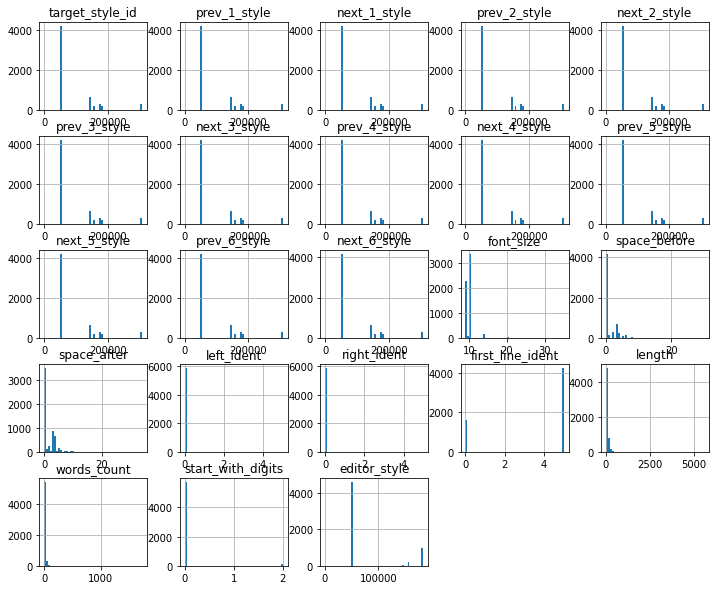

In [33]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Также есть огромные абзацы длиной более 1000 символов, но их количество крайне мало;  


3. Аналогична ситуация со словами - большинство абзацев содержат до 25 слов.

In [34]:
style_pivot = data2.pivot_table(
    index=['style_group', 'target_style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,target_style_,count_length,count_words_count,mean_length,mean_words_count
0,43507_1_978-5-534-18418-1.indd,[основной абзац],8,8,0.000000,0.000000
1,Петиты,Петит Внутри,696,696,76.899425,14.875000
2,Петиты,Петит Начало,347,347,102.755043,19.665706
3,Петиты,Петит Окончание,226,226,83.269912,16.659292
4,Петиты,Петит Полный,37,37,184.486486,37.162162
5,Пример с плашкой,Пример с плашкой_ Внутри,1,1,62.000000,7.000000
6,Рисунок,Подрисуночная подпись,94,94,9.404255,2.287234
7,Рисунок,Рисунок,88,88,1.000000,1.000000
8,Таблица,Табл. номер,6,6,11.000000,2.000000
9,Формулы,Формула 5 мм,120,120,7.658333,2.008333


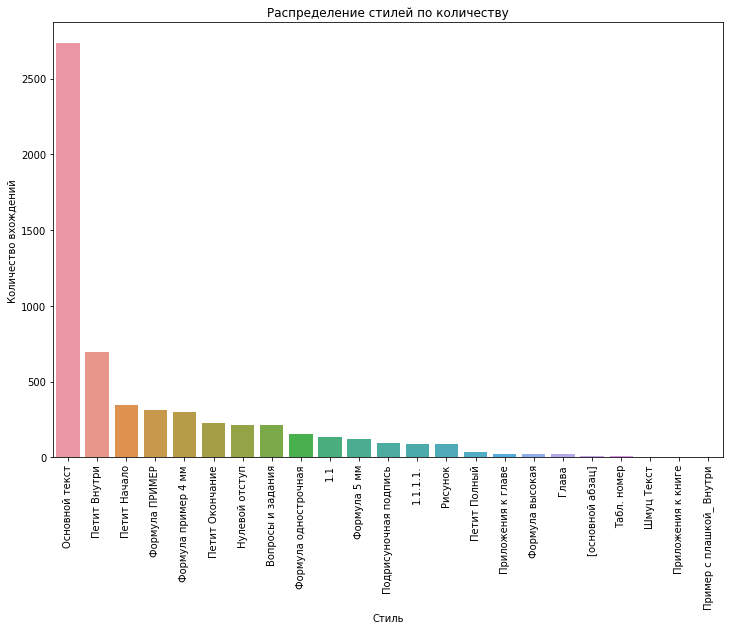

In [35]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Но в отличие от предыдущего, этот учебник имеет гораздо меньше контрольных вопросов.  
Зато куда как более щедр на примеры (стиль "Петит").

Снова большое количество формул, но рисунков уже меньше (~100).  
Опять можно сделать вывод, что это книжка по естественно-научной дисциплине.

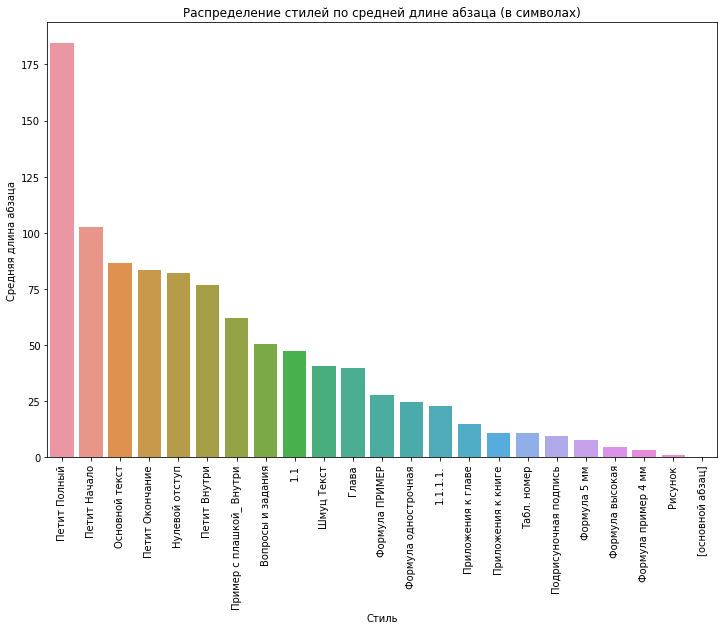

In [36]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - в примерах.
Основной текст лишь имеет абзацы со средней длиной около 85 символов.  
Хотя исходя из названия ("Практические задания по математике"), все становится на свои места:  
текст насущен недлинными условиями задач.


Возможно, статистика слегка прихрамывает из-за формул (которые считаются за один символ), но общую тенденцию тем не менее отражает.

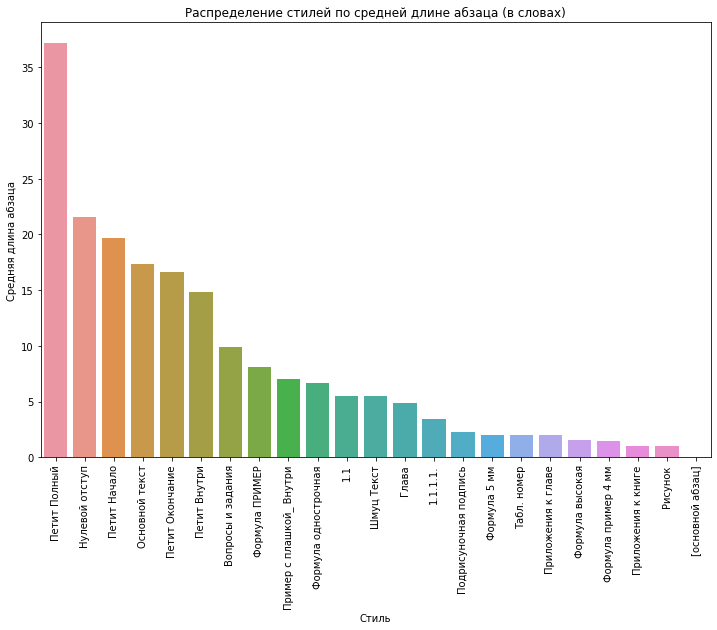

In [37]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

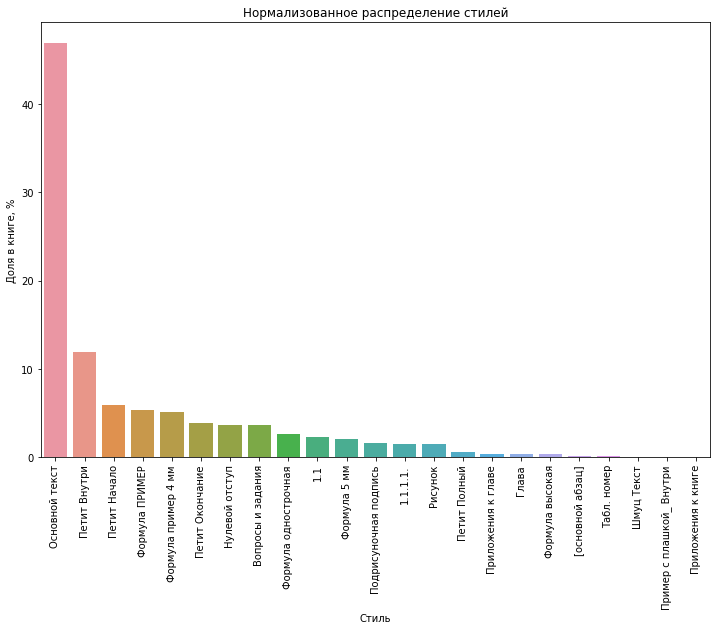

In [38]:
sns.barplot(
    x=data2['target_style'].value_counts(normalize=True).index,
    y=data2['target_style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Здесь почти половину абзацев всего текста составляет основной текст.

In [39]:
# Переопределим документ data3 =  3252

my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles(my_doc)

# Определим main_story
main_story3 = get_main_story(my_doc)

# Разобьем на абзацы и создадим еще один датафрейм
pre_data3 = get_paragraphs(main_story3)
data3 = features_engineering(pre_data3)

data3 = editor_emulate(data3)

data3

target_style Пример формула конец  is on!!!!
target_style Пример рисунок конец  is on!!!!
Max story length: 2515 
Stories: 766 
Max story index: 4
Paragraphs in max story: 2515


,paragraph,content,align,style_group,target_style_id,target_style,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_name,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,editor_style
0,<COMObject Item>,Список сокращений,Center,навигация по книге,50009,Приложения к книге,0,50004,0,50004,0,50004,0,50004,0,50004,0,50004,Myriad Pro,18.0,10.0,8.0,0.0,0.0,0.0,False,False,False,17,2,0,50009
1,<COMObject Item>,АД — артериальное давление,Justifed,основной набор,50004,Основной текст,50009,50004,0,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,26,4,0,50004
2,<COMObject Item>,АДГ — антидиуретический гормон (вазопрессин),Justifed,основной набор,50004,Основной текст,50004,50004,50009,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,44,5,0,50004
3,<COMObject Item>,АКТГ — адренокортикотропный гормон,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50009,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,34,4,0,50004
4,<COMObject Item>,АТФ — аденозинтрифосфат,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50009,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,23,3,0,50004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,<COMObject Item>,"11.\tФесенко, Ю. А. Возрастная физиология и пс...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,50004,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,213,35,0,50004
2510,<COMObject Item>,"12.\tВведенский, Н. Е. Избранные сочинения по ...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,158,29,0,50004
2511,<COMObject Item>,"13.\tМечников, И. И. Этюды о природе человека ...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,147,28,0,50004
2512,<COMObject Item>,"14.\tПавлов, И. П. Лекции о работе главных пищ...",Justifed,основной набор,50004,Основной текст,50004,50004,50004,0,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,146,26,0,50004


Тоже мельком посмотрим на статистику по этой книге

In [40]:
compare_styles(my_doc)

,style_id,style_group,style_name
0,97,3252_19_978-5-534-18025-1.indd,[Без стиля]
1,101,3252_19_978-5-534-18025-1.indd,[основной абзац]
16,312058,Пример с плашкой,Пример формула конец
17,312059,Пример с плашкой,Пример рисунок конец
18,312060,Пример с плашкой,Стиль абзаца 1
19,312061,Пример с плашкой,Стиль абзаца 2
25,312062,Пример с плашкой рубленый,Пример Р формула конец
26,312063,Пример с плашкой рубленый,Пример Р рисунок конец


In [41]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   paragraph          2514 non-null   object 
 1   content            2514 non-null   object 
 2   align              2514 non-null   object 
 3   style_group        2514 non-null   object 
 4   target_style_id    2514 non-null   int64  
 5   target_style       2514 non-null   object 
 6   prev_1_style       2514 non-null   int32  
 7   next_1_style       2514 non-null   int32  
 8   prev_2_style       2514 non-null   int32  
 9   next_2_style       2514 non-null   int32  
 10  prev_3_style       2514 non-null   int32  
 11  next_3_style       2514 non-null   int32  
 12  prev_4_style       2514 non-null   int32  
 13  next_4_style       2514 non-null   int32  
 14  prev_5_style       2514 non-null   int32  
 15  next_5_style       2514 non-null   int32  
 16  prev_6_style       2514 

In [42]:
data3.describe()

,target_style_id,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,length,words_count,start_with_digits,editor_style
count,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000
mean,67646.271679,67626.381464,67626.379475,67606.491249,67606.489260,67586.601034,67586.599045,67566.710819,67566.708831,67546.820605,67546.818616,67526.930390,67526.928401,10.398767,0.671639,0.515513,0.005569,0.005569,3.695306,300.099443,38.864757,0.101034,67368.612967
std,42965.298115,42985.038430,42985.039245,43004.760480,43004.761294,43024.464291,43024.465104,43044.149888,43044.150700,43063.817296,43063.818107,43083.466539,43083.467349,1.235901,1.420487,1.719009,0.205304,0.205304,2.196170,317.683423,40.297837,0.511055,42383.589468
min,50004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50004.000000
25%,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000,7.000000,0.000000,50004.000000
50%,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,50004.000000,10.500000,0.000000,0.000000,0.000000,0.000000,5.000000,168.500000,23.500000,0.000000,50004.000000
75%,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,50026.000000,10.500000,0.000000,0.000000,0.000000,0.000000,5.000000,483.000000,61.000000,0.000000,50026.000000
max,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,184116.000000,35.000000,10.000000,34.000000,9.000000,9.000000,5.000000,1886.000000,256.000000,3.000000,184117.000000


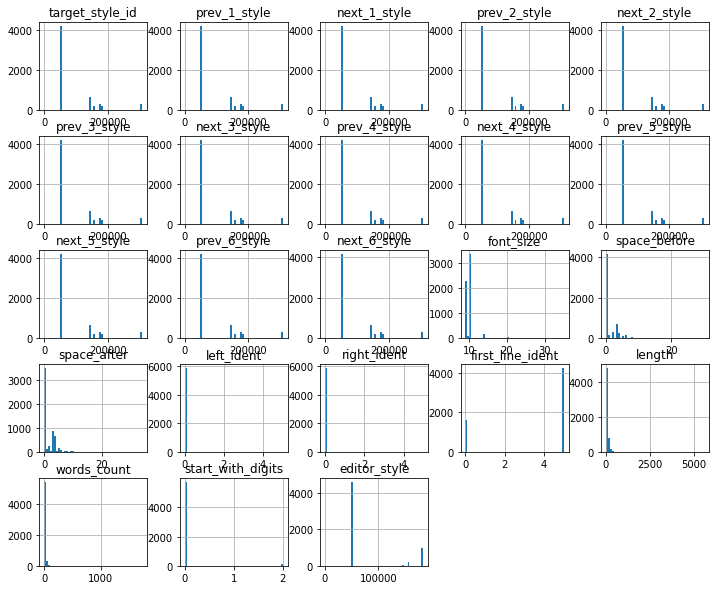

In [43]:
data2.hist(figsize=(12, 10), bins=50);

Из гистограмм видим:
1. Размер кегля преобладает 9 и 10,5;  


2. Снова преобладают короткие абзацы.  
Абзацы относительно прошлых книг доходят до 5000 символов;  


3. Аналогична ситуация со словами - есть абзацы в 1750 слов.

In [44]:
style_pivot = data3.pivot_table(
    index=['style_group', 'target_style'],
    #columns='content',
    values=['words_count', 'length'], 
    aggfunc=['count', 'mean']
    ).reset_index()

style_pivot.columns = ['_'.join(col) for col in style_pivot.columns]

style_pivot

,style_group_,target_style_,count_length,count_words_count,mean_length,mean_words_count
0,Преамбулы к главе,Преамбула к главе внутри,56,56,47.428571,6.053571
1,Преамбулы к главе,Преамбула к главе конец,5,5,38.400000,5.000000
2,Преамбулы к главе,Преамбула к главе начало,6,6,49.000000,7.000000
3,Пример с плашкой,Пример с плашкой_Конец,1,1,37.000000,5.000000
4,Рисунок,Легенда,64,64,145.031250,21.890625
5,Рисунок,Подрисуночная подпись,214,214,65.205607,8.677570
6,Рисунок,Рисунок,212,212,1.056604,1.028302
7,Рисунок,Рисунок - текст,1,1,0.000000,0.000000
8,Таблица,Табл. заголовок,12,12,57.916667,6.583333
9,Таблица,Табл. номер,12,12,11.000000,2.000000


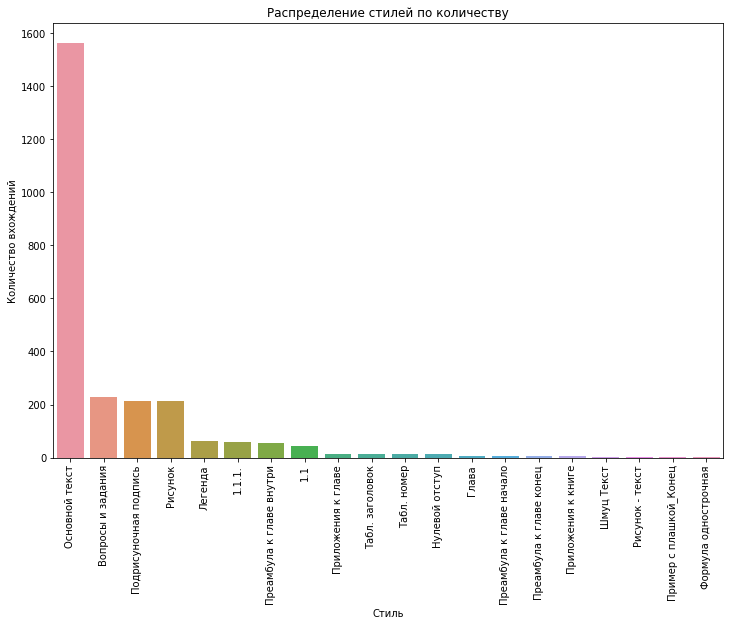

In [45]:
sns.barplot(
    x=style_pivot.sort_values(by='count_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='count_length', ascending=False)['count_length']
    )

plt.title('Распределение стилей по количеству')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


Аналогично предыдущей книге, основной текст - наиболее часто используемый стиль.

Также меньше контрольных вопросов, но изобилует рисунками (около 200 шт.).

Формул совсем нет. В наиболее часто используемых стилях видим практически все заголовки.  
Можно сделать вывод, что книга довольно простая по структуре (основной текст + вопросы + рисунки + заголовки).

Также в конце графика стиль конца примера ненавязчиво намекает, что он где-то ошибочно использован,  
поскольку нет ни начала, ни середины примера. 

Отметим этот факт как возможность генерации дополнительного признака о неправильной разметке.  

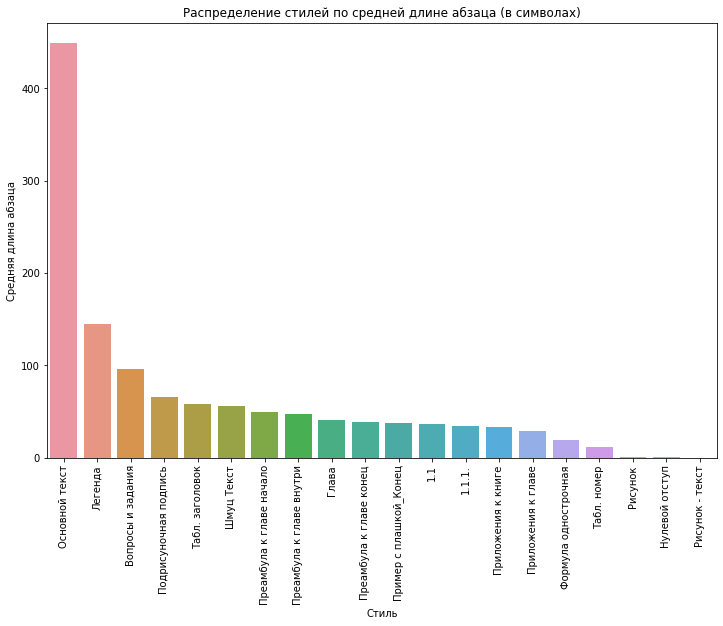

In [46]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_length', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_length', ascending=False)['mean_length']
    )

plt.title('Распределение стилей по средней длине абзаца (в символах)')
plt.xlabel('Стиль')
plt.ylabel('Средняя длина абзаца')
plt.xticks(rotation=90);


Самые длинные абзацы - основной текст - около 500 символов в среднем.  
Также заметим обширные легенды к рисункам.

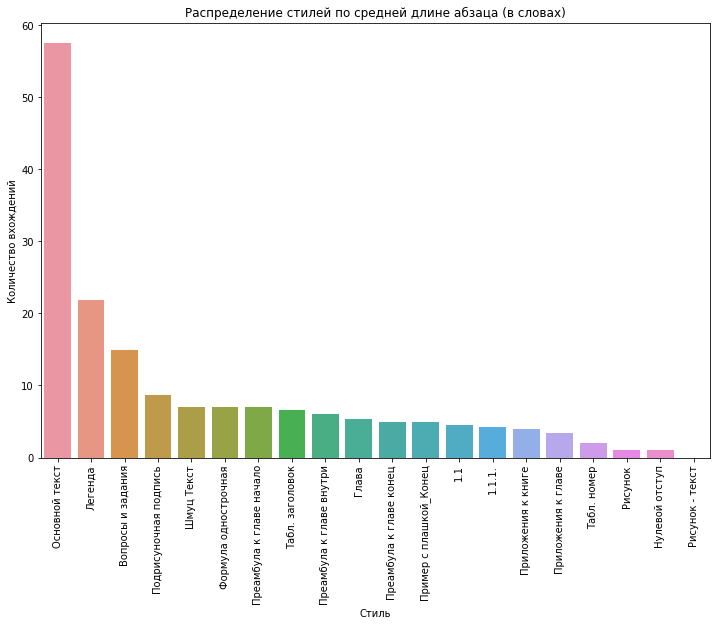

In [47]:
sns.barplot(
    x=style_pivot.sort_values(by='mean_words_count', ascending=False)['target_style_'],
    y=style_pivot.sort_values(by='mean_words_count', ascending=False)['mean_words_count']
    )

plt.title('Распределение стилей по средней длине абзаца (в словах)')
plt.xlabel('Стиль')
plt.ylabel('Количество вхождений')
plt.xticks(rotation=90);


И практически аналогичная картина при анализе по количеству слов.

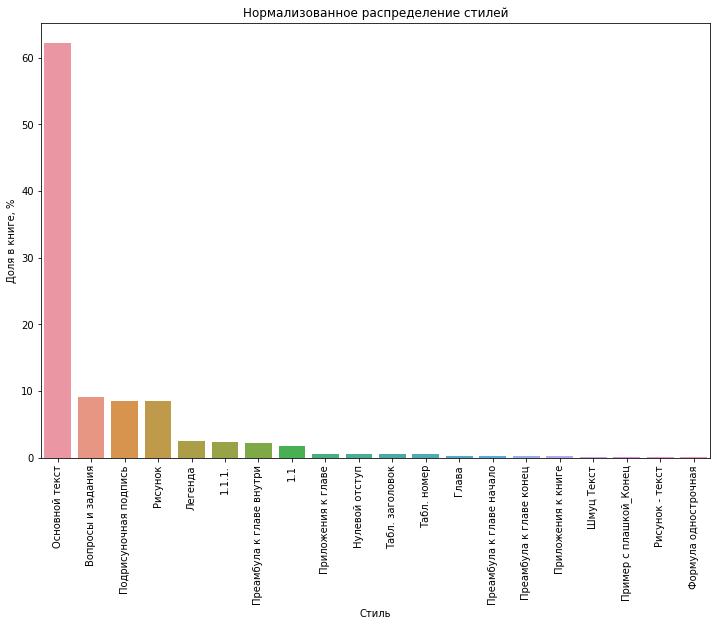

In [48]:
sns.barplot(
    x=data3['target_style'].value_counts(normalize=True).index,
    y=data3['target_style'].value_counts(normalize=True).values*100
    )

plt.title('Нормализованное распределение стилей')
plt.xlabel('Стиль')
plt.ylabel('Доля в книге, %')
plt.xticks(rotation=90);

Более 60 % книги - основной текст.  

In [49]:
# Переопределим документ data4 =  7212

my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles(my_doc)

# Определим main_story
main_story4 = get_main_story(my_doc)


#my_doc.close()

# Разобьем на абзацы и создадим еще один датафрейм
pre_data4 = get_paragraphs(main_story4)
data4 = features_engineering(pre_data4)
data4 = editor_emulate(data4)



Max story length: 4876 
Stories: 20 
Max story index: 4
Paragraphs in max story: 4876


In [50]:
data4

,paragraph,content,align,style_group,target_style_id,target_style,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_name,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,editor_style
0,<COMObject Item>,Авторский коллектив,Center,навигация по книге,50009,Приложения к книге,0,50004,0,50004,0,50004,0,50004,0,50004,0,50004,Myriad Pro,18.0,10.0,8.0,0.0,0.0,0.0,False,False,False,19,2,0,50009
1,<COMObject Item>,И. А. Антонов — начальник кафедры управления о...,Justifed,основной набор,50004,Основной текст,50009,50004,0,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,159,21,0,50004
2,<COMObject Item>,Б. Б. Булатов — профессор кафедры уголовного п...,Justifed,основной набор,50004,Основной текст,50004,50004,50009,50004,0,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,167,23,0,50004
3,<COMObject Item>,Б. Я. Гаврилов — профессор кафедры управления ...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50009,50004,0,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,252,31,0,50004
4,<COMObject Item>,В. Н. Григорьев — ведущий научный сотрудник На...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50009,50004,0,50004,0,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,235,36,0,50004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870,<COMObject Item>,7.\tУголовно-процессуальное право Российской Ф...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,50004,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,217,35,0,50004
4871,<COMObject Item>,8.\tУголовный процесс : учебник для вузов / А....,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,50004,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,159,31,0,50004
4872,<COMObject Item>,9.\tУголовный процесс : учебник для вузов / Б....,Justifed,основной набор,50004,Основной текст,50004,50004,50004,50004,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,177,34,0,50004
4873,<COMObject Item>,10.\tУголовный процесс : учебник для вузов / Б...,Justifed,основной набор,50004,Основной текст,50004,50004,50004,0,50004,0,50004,0,50004,0,50004,0,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,164,31,0,50004


In [51]:
compare_styles(my_doc)

,style_id,style_group,style_name
0,97,7212_5_978-5-534-18301-6.indd,[Без стиля]
1,101,7212_5_978-5-534-18301-6.indd,[основной абзац]
16,232910,Пример с плашкой,Пример формула конец
17,232911,Пример с плашкой,Пример рисунок конец
23,232912,Пример с плашкой рубленый,Пример Р формула конец
24,232913,Пример с плашкой рубленый,Пример Р рисунок конец


## Предобработка данных

Объединим данные. Столбец с объектом параграфа сразу удалим - он более не понадобится.

In [52]:
full_data = pd.concat([data, data2, data3, data4])

full_data.drop('paragraph', axis=1, inplace=True)

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20018 entries, 0 to 4874
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   content            20018 non-null  object 
 1   align              20018 non-null  object 
 2   style_group        20018 non-null  object 
 3   target_style_id    20018 non-null  int64  
 4   target_style       20018 non-null  object 
 5   prev_1_style       20018 non-null  int32  
 6   next_1_style       20018 non-null  int32  
 7   prev_2_style       20018 non-null  int32  
 8   next_2_style       20018 non-null  int32  
 9   prev_3_style       20018 non-null  int32  
 10  next_3_style       20018 non-null  int32  
 11  prev_4_style       20018 non-null  int32  
 12  next_4_style       20018 non-null  int32  
 13  prev_5_style       20018 non-null  int32  
 14  next_5_style       20018 non-null  int32  
 15  prev_6_style       20018 non-null  int32  
 16  next_6_style       2001

Проверим на пустые строки

In [53]:
full_data.query('content == ""')

,content,align,style_group,target_style_id,target_style,prev_1_style,next_1_style,prev_2_style,next_2_style,prev_3_style,next_3_style,prev_4_style,next_4_style,prev_5_style,next_5_style,prev_6_style,next_6_style,font_name,font_size,space_before,space_after,left_ident,right_ident,first_line_ident,is_pict_on,is_table_on,is_eqn_on,length,words_count,start_with_digits,editor_style
21,,Center,навигация по книге,50012,Глава,50011,50012,50004,50008,50004,50004,50004,50004,50004,50004,50004,50004,Myriad Pro,20.0,1.0,5.0,0.0,0.0,0.0,False,False,False,0,0,0,50012
103,,Left,43507_1_978-5-534-18418-1.indd,101,[основной абзац],50004,50012,50004,50008,50004,50004,50004,50005,50004,156138,144284,50004,Minion Pro,12.0,0.0,0.0,0.0,0.0,0.0,False,False,False,0,0,0,101
341,,Justifed,основной набор,50004,Основной текст,50026,50011,50026,50012,50026,50012,50026,50008,50026,50004,50016,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50004
343,,Center,навигация по книге,50012,Глава,50011,50012,50004,50008,50026,50004,50026,50004,50026,50004,50026,50004,Myriad Pro,20.0,1.0,5.0,0.0,0.0,0.0,False,False,False,0,0,0,50012
1016,,Justifed,основной набор,50004,Основной текст,50026,101,50026,50012,50026,50008,50026,50004,50026,50004,50016,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4513,,Justifed,основной набор,50026,Вопросы и задания,50026,50011,50026,50012,50026,50008,50026,50004,50026,50004,50026,50004,CharterITC,9.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50026
4704,,Justifed,основной набор,50004,Основной текст,50026,50011,50026,50012,50026,50008,50026,50004,50026,50004,50026,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50004
4794,,Justifed,основной набор,50004,Основной текст,50026,50011,50026,50012,50026,50008,50026,50004,50026,50004,50026,50004,CharterITC,10.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50004
4861,,Justifed,основной набор,50026,Вопросы и задания,50026,50026,50026,50009,50026,50004,50026,50004,50026,50004,50026,50004,CharterITC,9.5,0.0,0.0,0.0,0.0,5.0,False,False,False,0,0,0,50026


In [54]:
full_data = full_data.query('content != ""')

In [55]:
full_data['style_group'].unique()

array(['навигация по книге', 'основной набор', 'Преамбулы к главе',
       'Пример с плашкой', 'Формулы', 'Пример с плашкой рубленый',
       'Таблица', 'Рисунок', 'Петиты'], dtype=object)

In [56]:
full_data['target_style_id'].unique()

array([ 50009,  50004,  50012, 144255, 156677, 156680, 156679,  50008,
        50016, 177463, 177705, 177466,  50005, 184114, 184117,  50020,
       177450, 275290, 184319, 184115, 184116,  50030, 156138, 144914,
        50026,  50006, 275289, 279574, 184113,  50015, 184112, 317943,
       317942,  50011, 144279, 144280, 144284,  50028, 308909, 144264,
        50019], dtype=int64)

In [57]:
full_data.groupby(['style_group', 'target_style'])['font_name'].agg('count').sort_values()

style_group                target_style               
Таблица                    Табл. заголовок                  12
навигация по книге         Шмуц Текст                       13
Пример с плашкой рубленый  Пример Р рисунок конец           13
Пример с плашкой           Пример рисунок конец             14
навигация по книге         Приложения к книге               15
Таблица                    Табл. номер                      20
Преамбулы к главе          Преамбула к главе конец          25
                           Преамбула к главе начало         26
Пример с плашкой рубленый  Пример с плашкой_Без плашки      28
                           Пример с плашкой_Полный          30
                           Пример Р формула конец           33
Пример с плашкой           Пример формула конец             34
Петиты                     Петит Полный                     37
Пример с плашкой           Пример с плашкой_Конец           43
навигация по книге         1.1.1.                           60


In [66]:
#full_data.columns
#full_data.drop(['paragraph', 'content'], axis=1, inplace=True)

#full_data.to_csv('Data\dataset.csv', encoding='utf-8')
os.path.abspath("sp.ipynb")

'e:\\Ya_Pr\\InDesign\\sp.ipynb'

## Краткий вывод

Для подготовки данных к машинному обучению создан набор данных из трех книг.

Данные бегло исследованы, объединены в один датафрейм.

Удалены строки без значений конетента, остальные признаки проверены на адекватность значений.

## Подготовка данных для машинного обучения



In [ ]:
full_data = pd.read_csv('Data\dataset.csv', index_col=[0])

full_data

In [ ]:
full_data['target_style'].value_counts()

In [ ]:
# full_data = full_data[full_data['group+style'] != '7212_5_978-5-534-18301-6.indd &&& [Без стиля]']

In [ ]:
full_data.columns

In [ ]:
ohe_cols = ['align', 'style_group', 'font_name', 'is_pict_on', 'is_table_on', 'is_eqn_on'] # 
me_cols = ['editor_style', 
           'prev_1_style', 'next_1_style', 'prev_2_style', 'next_2_style',
           'prev_3_style', 'next_3_style', 'prev_4_style', 'next_4_style',
           'prev_5_style', 'next_5_style', 'prev_6_style', 'next_6_style',] # 
category_cols = ohe_cols + me_cols


numeric_cols = ['font_size', 'space_before', 'space_after', 
                'left_ident', 'right_ident', 'first_line_ident', 
                'length', 'words_count', 'start_with_digits'
                ]

X = full_data[ohe_cols + me_cols + numeric_cols]
y = full_data['target_style_id']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=.75, 
    random_state=RS,
    stratify=y
    )

# X_train[numeric_cols] = X_train[numeric_cols].astype('float')
# X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [ ]:
X_train[category_cols] = X_train[category_cols].astype('category')
X_test[category_cols] = X_test[category_cols].astype('category')

X_train[numeric_cols] = X_train[numeric_cols].astype('float')
X_test[numeric_cols] = X_test[numeric_cols].astype('float')

In [ ]:
# le = LabelEncoder()

# #le.fit(y)
# y_train = le.fit_transform(y_train)

# y_test = le.transform(y_test)

Создадим пайплайн обработки

In [ ]:
num_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
me_encoder = MEstimateEncoder()

pipe_num = Pipeline([('imputer', num_imputer), ('scaler', std_scaler)])

pipe_ohe = Pipeline([('ohe_encoder', ohe_encoder)])

pipe_me = Pipeline([('me_encoder', me_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, numeric_cols),
                                     ('ohe_preproc', pipe_ohe, ohe_cols),
                                     ('me_prerpoc', pipe_me, me_cols)
                                    ])

fin_pipe = Pipeline([('full_prep', col_transformer)])

In [ ]:
X_train_transformed = fin_pipe.fit_transform(X_train, y_train)

X_test_transformed = fin_pipe.transform(X_test)

In [ ]:
X_train_transformed

#### LogisticRegression

In [ ]:
model_lr = LogisticRegression(random_state=RS, max_iter=5000, multi_class='auto', verbose=0, class_weight='balanced')

model_lr.fit(X_train_transformed, y_train)

scores = cross_val_score(model_lr, X_train_transformed, y_train, scoring='f1_weighted')



print('\nF1-score:', scores.mean(), '\n')

In [ ]:
# посмотрим, как вообще предсказывает

preds = model_lr.predict(X_test_transformed)
t = pd.DataFrame(data=[preds, y_test]).T
t.columns = ['preds', 'fact']

t[t['preds'] != t['fact']]

Подберем гиперпараметры с помощью Optuna

In [ ]:
# Общие параметры
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

In [ ]:
def objective_lr(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.001, 0.01, log=True)
    C = trial.suggest_float("C", 5.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    classifier = LogisticRegression(random_state=RS, 
                                    max_iter=1500,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class='auto',
                                    class_weight='balanced',
                                    n_jobs=-1,
                                    verbose=0
                                   )
    
    classifier.fit(X_train_transformed, y_train)

    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1_weighted', cv=3)

    return scores.mean()

In [ ]:
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize", sampler=sampler)
study_lr.optimize(objective_lr, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_lr.trials))
print('Best trial:')
trial = study_lr.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_LR = trial.value
best_model_LR = LogisticRegression(**trial.params, 
                                   random_state=RS, 
                                   multi_class='auto',
                                   class_weight='balanced',
                                   n_jobs=-1,
                                   verbose=0
                                   )



#### LightGBM

In [ ]:
# Функция подбора гиперпараметров LightGBM

def objective_LGBM(trial):
    params = {
        # Hyperparameter settings
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 6, 306, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 1000, step=40),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.95),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0.1, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0.1, 100, step=1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
        
    }
    
    model = LGBMClassifier(**params, class_weight='balanced', n_jobs=-1, random_state=RS, verbose=-1)  
    
    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted')
    
    
    return scores.mean()

In [ ]:
study_LGBM = optuna.create_study(study_name="LightGBM", direction="maximize", sampler=sampler)
study_LGBM.optimize(objective_LGBM, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_LGBM.trials))
print('Best trial:')
trial = study_LGBM.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_LGBM = trial.value
best_model_LGBM = LGBMClassifier(**trial.params, 
                                 class_weight='balanced', 
                                 n_jobs=-1, 
                                 random_state=RS, 
                                 verbose=-1)

#### CatBoost

Кодированные данные

In [ ]:
def objective_CB_enc(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 600, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 2, 6),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    model = CatBoostClassifier(**params,
                               loss_function='MultiClassOneVsAll', 
                               class_weights=class_weights, 
                               random_state=RS, 
                               verbose=False,
                               task_type="GPU",
                               devices='0:1'
    )

    model.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(model, X_train_transformed, y_train, scoring='f1_weighted')
    
    
    return scores.mean()


In [ ]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="maximize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_CB_enc = trial.value

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

best_model_CB_enc = CatBoostClassifier(**trial.params,
                                       loss_function='MultiClassOneVsAll', 
                                       class_weights=class_weights, 
                                       random_state=RS, 
                                       verbose=False, 
                                       task_type="GPU",
                                       devices='0:1')

In [ ]:
# best_model_CB_enc.fit(X_train_transformed, y_train)


Некодированнные данные

In [ ]:
def objective_CB_orig(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 600, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 2, 6),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    

    model = CatBoostClassifier(**params, 
                              loss_function='MultiClassOneVsAll', 
                              class_weights=class_weights, 
                              random_state=RS,
                              verbose=False,
                              task_type="GPU",
                              devices='0:1',
                              cat_features=['align', 'style_group', 'font_name', 
                                            'is_pict_on', 'is_table_on', 'is_eqn_on', 
                                            'editor_style', 
                                            'prev_1_style', 'next_1_style', 'prev_2_style', 'next_2_style',
                                            'prev_3_style', 'next_3_style', 'prev_4_style', 'next_4_style',
                                            'prev_5_style', 'next_5_style', 'prev_6_style', 'next_6_style'] ,
)

    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted')
    
    
    return scores.mean()

In [ ]:
# X_train['font_size'] = X_train['font_size'].astype(float)

X_train.info()

In [ ]:
study_CB_orig = optuna.create_study(study_name="catboost_orig", direction="maximize", sampler=sampler)
study_CB_orig.optimize(objective_CB_orig, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_CB_orig.trials))
print('Best trial:')
trial = study_CB_orig.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_CB_orig = trial.value

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

best_model_CB_orig = CatBoostClassifier(**trial.params, 
                                        loss_function='MultiClassOneVsAll', 
                                        class_weights=class_weights, 
                                        random_state=RS,
                                        verbose=False, 
                                        task_type="GPU",
                                        devices='0:1',
                                        cat_features=category_cols)

Попробуем добавить текстовые данные.

In [ ]:
full_data_text = full_data.reset_index().copy()

#full_data_emb[full_data_emb['words_count'] == 1]

full_data_text['editor_style'].unique()
#full_data.reset_index()['content'][1].split()[0] +' ' + full_data.reset_index()['content'][1].split()[1]

In [ ]:
full_data_text.drop(['index', 'target_style'],axis=1, inplace=True)

full_data_text.info()#.target_style_id.unique()

In [ ]:
cat_cols = ['align',
            'style_group',
            'font_name',
            'is_pict_on',
            'is_table_on',
            'is_eqn_on', 
            'prev_second_style',
            'prev_style',
            'editor_style',
            'next_style', 
            'next_second_style'] # 


numeric_cols = ['space_before', 'space_after', 'font_size',
                'left_ident', 'right_ident', 'first_line_ident', 
                'length', 'words_count', 'start_with_digits'
                ]

text_cols = ['content']

In [ ]:
X = full_data_text.drop('target_style_id', axis=1)
y = full_data_text['target_style_id']

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=.75, 
    random_state=RS,
    stratify=y
    )

In [ ]:
cb_text = CatBoostClassifier(#**params, 
                            loss_function='MultiClassOneVsAll', 
                            auto_class_weights='Balanced', 
                            random_state=RS,
                            verbose=False,
                            task_type="GPU",
                            devices='0:1',
                            cat_features=category_cols,
                            text_features=text_cols
                                        
)

cb_text.fit(X_text_train, y_train)

scores = cross_val_score(cb_text, X_text_train, y_train, scoring='f1_weighted', cv=5)

In [ ]:
def objective_CB_text(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 600, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 2, 6),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**params, 
                              loss_function='MultiClassOneVsAll', 
                              auto_class_weights='Balanced', 
                              random_state=RS,
                              verbose=False,
                              task_type="GPU",
                              devices='0:1',
                              cat_features=category_cols,
                              text_features=text_cols
    )

    model.fit(X_text_train, y_train)
    
    scores = cross_val_score(model, X_text_train, y_train, scoring='f1_weighted')
    
    
    return scores.mean()




In [ ]:
study_CB_text = optuna.create_study(study_name="catboost_text", direction="maximize", sampler=sampler)
study_CB_text.optimize(objective_CB_text, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_CB_text.trials))
print('Best trial:')
trial = study_CB_text.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_CB_text = trial.value

best_model_CB_text = CatBoostClassifier(**trial.params, 
                                        loss_function='MultiClassOneVsAll', 
                                        class_weights=class_weights, 
                                        random_state=RS,
                                        verbose=False, 
                                        task_type="GPU",
                                        devices='0:1',
                                        cat_features=category_cols,
                                        text_features=text_cols
)

### Предварительный итог

Сведем результаты в таблицу.

In [ ]:
best_model_LR.fit(X_train_transformed, y_train)

best_model_LGBM.fit(X_train_transformed, y_train)

best_model_CB_enc.fit(X_train_transformed, y_train)

best_model_CB_orig.fit(X_train, y_train)

best_model_CB_text.fit(X_text_train, y_train)

In [ ]:
best_recall_LR = recall_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_recall_LGBM = recall_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_recall_CB = recall_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')
best_recall_CB_or = recall_score(y_train, best_model_CB_orig.predict(X_train), average='weighted')
best_recall_CB_text = recall_score(y_train, best_model_CB_text.predict(X_text_train), average='weighted')


best_precision_LR = precision_score(y_train, best_model_LR.predict(X_train_transformed), average='weighted')
best_precision_LGBM = precision_score(y_train, best_model_LGBM.predict(X_train_transformed), average='weighted')
best_precision_CB = precision_score(y_train, best_model_CB_enc.predict(X_train_transformed), average='weighted')
best_precision_CB_or = precision_score(y_train, best_model_CB_orig.predict(X_train), average='weighted')
best_precision_CB_text = precision_score(y_train, best_model_CB_text.predict(X_text_train), average='weighted')


best_accuracy_LR = accuracy_score(y_train, best_model_LR.predict(X_train_transformed))
best_accuracy_LGBM = accuracy_score(y_train, best_model_LGBM.predict(X_train_transformed))
best_accuracy_CB = accuracy_score(y_train, best_model_CB_enc.predict(X_train_transformed))
best_accuracy_CB_or = accuracy_score(y_train, best_model_CB_orig.predict(X_train))
best_accuracy_CB_text = accuracy_score(y_train, best_model_CB_text.predict(X_text_train))


In [ ]:
train_score = pd.DataFrame({
    'LogisticRegression' : [best_f1_LR, best_accuracy_LR, best_precision_LR, best_recall_LR],
    'LightGBM': [best_f1_LGBM, best_accuracy_LGBM, best_precision_LGBM, best_recall_LGBM],
    'CatBoost_enc': [best_f1_CB_enc, best_accuracy_CB, best_precision_CB, best_recall_CB],
    'CatBoost_orig': [best_f1_CB_orig, best_accuracy_CB_or, best_precision_CB_or, best_recall_CB_or],
    'CatBoost_text': [best_f1_CB_text, best_accuracy_CB_text, best_precision_CB_text, best_recall_CB_text],

}, index=['F1-Score', 'Accuracy', 'Precision', 'Recall'])

In [ ]:
train_score

In [ ]:
train_score.plot(kind='bar', ylim=(0.95, 1));

Как видно, CatBoost показал себя лучше по всем метрикам

In [ ]:
best_model_CB_enc.save_model(fname='Data\Models\cb_model',
                             format="cbm",
                             export_parameters=None,
                             pool=None)

best_model_CB_text.save_model(fname='Data\Models\cb_model_text',
                             format="cbm",
                             export_parameters=None,
                             pool=None)

best_model_CB_orig.save_model(fname='Data\Models\cb_model_orig',
                             format="cbm",
                             export_parameters=None,
                             pool=None)

#### BERT

In [ ]:
# Заново объединим данные, так как лемматизация и очистка текста проходят внутри Берты
data_bert = full_data # pd.concat([data, data2, data3, data4])

In [ ]:
data_bert['content'] = data_bert['content'].apply(lambda x: x[:512])

In [ ]:
# from transformers import BertForSequenceClassification

config = transformers.BertConfig.from_pretrained('cointegrated/rubert-tiny')
model = transformers.BertModel.from_pretrained('cointegrated/rubert-tiny')

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')

tokenized = data_bert['content'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
padded.shape

In [ ]:
batch_size = 32

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

Добавим эмбединги в модель с текстовыми признаками

In [ ]:
features = np.concatenate(embeddings)
# Добавить признаки из датасета?

target = data_bert['target_style_id'][:features.shape[0]]
data_bert = data_bert[:features.shape[0]].drop(['target_style_id', 'target_style'], axis=1)



In [ ]:
data_bert['embedings'] = features.tolist()

#len(features[0])



In [ ]:
embeddings_features = ['embedings']

embeddings_features

In [ ]:
#features = pd.concat([data_bert.drop(['target_style_id', 'target_style'], axis=1), pd.DataFrame(features)], axis=1)

In [ ]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
                data_bert, 
                target, 
                train_size=.8, 
                stratify=target, 
                random_state=RS
            
            )


In [ ]:
X_bert_train

In [ ]:
def objective_CB_emb(trial):
    params = {
        "iterations" : trial.suggest_int('iterations', 600, 800),
        "learning_rate" : trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        "depth" : trial.suggest_int('depth', 2, 6),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        "bootstrap_type" : trial.suggest_categorical('bootstrap_type', ['Bayesian']),
        "random_strength" : trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float('bagging_temperature', 0.0, 10.0),
        "od_type" : trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        "od_wait" : trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**params, 
                              loss_function='MultiClassOneVsAll', 
                              auto_class_weights='Balanced', 
                              random_state=RS,
                              verbose=False,
                              task_type="GPU",
                              devices='0:1',
                              cat_features=category_cols,
                              text_features=text_cols,
                              embedding_features=embeddings_features
    )

    model.fit(X_bert_train, y_bert_train)
    
    scores = cross_val_score(model, X_bert_train, y_bert_train, scoring='f1_weighted')
    
    
    return scores.mean()

In [ ]:
study_CB_emb = optuna.create_study(study_name="catboost_emb", direction="maximize", sampler=sampler)
study_CB_emb.optimize(objective_CB_emb, show_progress_bar=True, n_trials=100)

In [ ]:
print('Number of finished trials: ', len(study_CB_emb.trials))
print('Best trial:')
trial = study_CB_emb.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



In [ ]:
best_f1_CB_emb = trial.value

best_model_CB_emb = CatBoostClassifier(**trial.params, 
                                        loss_function='MultiClassOneVsAll', 
                                        class_weights=class_weights, 
                                        random_state=RS,
                                        verbose=False, 
                                        task_type="GPU",
                                        devices='0:1',
                                        cat_features=category_cols,
                                        text_features=text_cols,
                                        embedding_features=embeddings
)

In [ ]:
best_recall_CB_emb = recall_score(y_bert_train, best_model_CB_emb.predict(X_bert_train), average='weighted')

best_precision_CB_emb = precision_score(y_bert_train, best_model_CB_emb.predict(X_bert_train), average='weighted')

best_accuracy_CB_emb = accuracy_score(y_bert_train, best_model_CB_emb.predict(X_bert_train))


In [ ]:
train_score['CatBoost_emb'] = [best_f1_CB_emb, best_recall_CB_emb, best_precision_CB_emb, best_accuracy_CB_emb]

train_score

## Проверка на тестовой выборке

Проверим лучшую модель на тестовой выборке.

In [ ]:
f1_score(y_test, best_model_CB_enc.predict(X_test_transformed), average='weighted')

In [ ]:
X_test_inversed = pd.DataFrame(X_test_transformed)
#X_test_inversed

In [ ]:
# X_test_inversed = ohe_encoder.inverse_transform(X_train_transformed)
# X_test_inversed

ohe_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[1][1].named_steps['ohe_encoder']
me_cols_inversed = fin_pipe.named_steps['full_prep'].transformers_[2][1].named_steps['me_encoder']

cols_inversed = me_cols_inversed.get_feature_names_out(me_cols).tolist() + ohe_cols_inversed.get_feature_names_out(ohe_cols).tolist() + numeric_cols

X_test_inversed.columns = (x for x in cols_inversed)

ohe_cols_inversed.inverse_transform(X_test_inversed[ohe_cols_inversed.get_feature_names_out(ohe_cols).tolist()])
#ohe_encoder.inverse_transform(X_test_inversed)

In [ ]:
sns.barplot(
    x=X_test_inversed.columns,
    y=best_model_CB_enc.feature_importances_
)

plt.title('Важность признаков')
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность');

## Проверка в боевых условиях

In [ ]:
# Переопределим документ 
my_doc = app.ActiveDocument


In [ ]:

# Добавим стили, если их нет
add_styles(my_doc)

# Определим main_story
main_story_battletest = get_main_story(my_doc)

# Разобьем на абзацы и создадим еще один датафрейм
pre_data_battletest = get_paragraphs(main_story_battletest)
data_battletest = features_engineering(pre_data_battletest)
data_battletest = editor_emulate(data_battletest)

data_battletest

In [ ]:
data_battletest['align'].unique()

In [ ]:
compare_styles(my_doc)

In [ ]:
real_styles = data_battletest[['style_group', 'target_style']]

#data_battletest = data_battletest.drop(['paragraph', 'content', 'target_style', 'group+style'], axis=1)

In [ ]:
data_battletest_transformed = fin_pipe.transform(data_battletest.drop(['paragraph', 'content', 'target_style'], axis=1))

In [ ]:
pd.DataFrame(data_battletest_transformed)

In [ ]:
predictions = best_model_CB_enc.predict(data_battletest_transformed)
predictions = le.inverse_transform(predictions)

predictions.shape

In [ ]:
predict_dataframe = pd.DataFrame(predictions, columns=['group+style'])

predict_dataframe['style_group'] = predict_dataframe['group+style'].apply(lambda x: x.split(' &&& ')[0])
predict_dataframe['target_style'] = predict_dataframe['group+style'].apply(lambda x: x.split(' &&& ')[1])

data_battletest['group+style'].unique()

In [ ]:
#real_styles['style_group'].unique()

data_battletest
#i=1

#my_doc.name
#main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc.allparagraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['target_style'][i])

In [ ]:
# Добавим цвет для выделения измененных абзацев

new_color = my_doc.colors.add()
my_doc.Swatches.item(-1).name = 'Changes'
my_doc.Swatches.item(-1).colorValue = [100, 0, 100, 0]


In [ ]:
# main_story_battletest.paragraphs.Item(1).fillColor = 'Changes'

main_story.paragraphs.Item(1).fillColor = 'Changes'



In [ ]:
for i in range(0, main_story_battletest.Paragraphs.Count):
    if (real_styles['target_style'][i] != predict_dataframe['target_style'][i]) & (real_styles['style_group'][i] != predict_dataframe['style_group'][i]):
        # print('Real:   ', real_styles['style_group'][i], real_styles['target_style'][i], '\n')
        # print('Predict:', predict_dataframe['style_group'][i], predict_dataframe['target_style'][i], '\n')
        # print('-'*20)

        if predict_dataframe['style_group'][i] == 'основной набор':
            main_story_battletest.paragraphs.Item(i).appliedParagraphStyle = my_doc.paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['target_style'][i])
            main_story_battletest.paragraphs.Item(i).fillColor = 'Changes'
            print('Paragraph', i, 'added style', predict_dataframe['target_style'][i], 'from', predict_dataframe['style_group'][i])
        elif predict_dataframe['style_group'][i] in [
                                                    'Рисунок',
                                                    'Формулы',
                                                    'Пример с плашкой',
                                                    'Пример с плашкой рубленый',
                                                    'Преамбулы к главе',
                                                    'Петиты',
                                                    'Код',
                                                    'Таблица'
                                                    ]:
            main_story_battletest.paragraphs.Item(i).appliedParagraphStyle = my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['target_style'][i])
            main_story_battletest.paragraphs.Item(i).fillColor = 'Changes'
            print('Paragraph', i, 'added style', predict_dataframe['target_style'][i], 'from', predict_dataframe['style_group'][i])
        else:
            main_story_battletest.paragraphs.Item(1).appliedParagraphStyle = my_doc.paragraphStyleGroups.item(predict_dataframe['style_group'][i]).paragraphStyles.item(predict_dataframe['target_style'][i])
            main_story_battletest.paragraphs.Item(i).fillColor = 'Changes'
            print('Paragraph', i, 'added style', predict_dataframe['target_style'][i], 'from', predict_dataframe['style_group'][i])


        # main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc_battletest.allParagraphStyles[styles[predictions[i]]]
        # main_story_battletest.paragraphs.Item(i+1).fillColor = my_color


# my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример формула конец')

# Покрасить параграфы с изменением стиля!
# Менять только измененные стили!

In [ ]:
res = pd.DataFrame({'real': real_styles['target_style'], 'predictions': predict_dataframe['target_style']},)

#res.query('real != predictions')

res.predictions.unique()

In [ ]:
data

## Тестовый блок

In [ ]:
# Переопределим документ data2 = 43507
my_doc = app.ActiveDocument

# Добавим стили, если их нет
add_styles(my_doc)

# Определим main_story
main_story_test = get_main_story(my_doc)

# Разобьем на абзацы и создадим еще один датафрейм
pre_data_test = get_paragraphs(main_story_test)
data_test = features_engineering(pre_data_test)

data_test = editor_emulate(data_test)

data_test

In [ ]:
t = data_test # backup

#data_test['editor_style'].unique()

data_test[['target_style_id', 'prev_second_style', 'prev_style', 'next_style', 'next_second_style']] = data_test[['target_style_id', 'prev_second_style', 'prev_style', 'next_style', 'next_second_style']].astype('Int64')
data_test.fillna(0, inplace=True)
data_test[['target_style_id', 'prev_second_style', 'prev_style', 'next_style', 'next_second_style']] = data_test[['target_style_id', 'prev_second_style', 'prev_style', 'next_style', 'next_second_style']].astype('int')


real_styles = data_test[['target_style', 'target_style_id']]
data_test.drop(['paragraph', 'target_style', 'target_style_id'], axis=1, inplace=True)

In [ ]:
data_test.info()

In [ ]:

#print(data_test['paragraph'][2].appliedParagraphStyle.id)
print(my_doc.AllParagraphStyles.Item(11).name)
print(my_doc.AllParagraphStyles.Item(11).id)


In [ ]:
# preds = le.inverse_transform(best_model_LR.predict(data_battletest_transformed))
# pd.DataFrame(data=[preds, data_battletest['target_style_id']]).T

preds = cb_text.predict(data_test)
real_styles['prediction'] = preds

real_styles.query('prediction != target_style_id')


In [ ]:
for i in range(1, main_story_test.Paragraphs.Count):
    if (preds[i-1] != real_styles['target_style_id'][i-1]):
        
        print('Predicted style:', my_doc.allParagraphStyles.ItemByID(preds[i-1]).name)
        print('Paragraph content:', main_story_test.paragraphs.Item(i).contents)
        print('Real style:', main_story_test.paragraphs.Item(i).appliedParagraphStyle.name)
        print(i,'-'*25, '\n')
        
        # 
        main_story_test.paragraphs.Item(i).appliedParagraphStyle = my_doc.allParagraphStyles.ItemByID(preds[i-1])
        main_story_test.paragraphs.Item(i).fillColor = 'Changes'
        # print('Paragraph', i, 'added style id:', my_doc.allParagraphStyles.ItemByID(preds[i-1]).name)

        


        # main_story_battletest.paragraphs.Item(i+1).appliedParagraphStyle = my_doc_battletest.allParagraphStyles[styles[predictions[i]]]
        # main_story_battletest.paragraphs.Item(i+1).fillColor = my_color


# my_doc.paragraphStyleGroups.item('основной набор').paragraphStyleGroups.item('Пример с плашкой').paragraphStyles.item('Пример формула конец')

# Покрасить параграфы с изменением стиля!
# Менять только измененные стили!

In [ ]:
my_doc.allParagraphStyles.ItemByID(177466).name

In [ ]:
main_story_battletest.paragraphs.item(1).contents